In [46]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from scipy.optimize import minimize


tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'NFLX', 'TSLA']
start_date = '2023-01-01'
end_date = '2025-01-01'

# Download adjusted close prices and compute daily returns
data = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna()
returns = data.pct_change().dropna()  # DataFrame of shape (n_samples, n_assets)

# PCA - using eigenvalue decomposition for simplicity
def perform_pca(diffdat, n_components=None):
    # Standardize data (mean = 0)
    mean_diffdat = np.mean(diffdat, axis=0)
    std_diffdat = np.std(diffdat, axis=0, ddof=1)
    
    # Standardize the data (like scale=TRUE in R)
    diffdat_standardized = (diffdat - mean_diffdat) / std_diffdat
    
    # Covariance matrix of standardized data
    cov_matrix = np.cov(diffdat_standardized, rowvar=False)
    
    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # If a number of components is specified, select only the first n_components
    if n_components is not None:
        eigenvalues = eigenvalues[:n_components]
        eigenvectors = eigenvectors[:, :n_components]
    
    # Compute principal component scores
    P = diffdat_standardized @ eigenvectors
    
    return eigenvalues, eigenvectors, P, mean_diffdat, std_diffdat
diffdat = returns.values

# Use custom PCA and select only the first three components
n_components = 3
eigenvalues, eigenvectors, P, mean_diffdat, std_diffdat = perform_pca(diffdat, n_components=n_components)

# Create a DataFrame for the principal components (PCs)
PCs = pd.DataFrame(P, index=returns.index, 
                   columns=[f'PC{i+1}' for i in range(P.shape[1])])
print("Explained variances (proportions):", eigenvalues / eigenvalues.sum())

[*********************100%***********************]  7 of 7 completed

Explained variances (proportions): [0.68869998 0.16696087 0.14433914]


Estimated Correlation Matrix for Gaussian Copula:


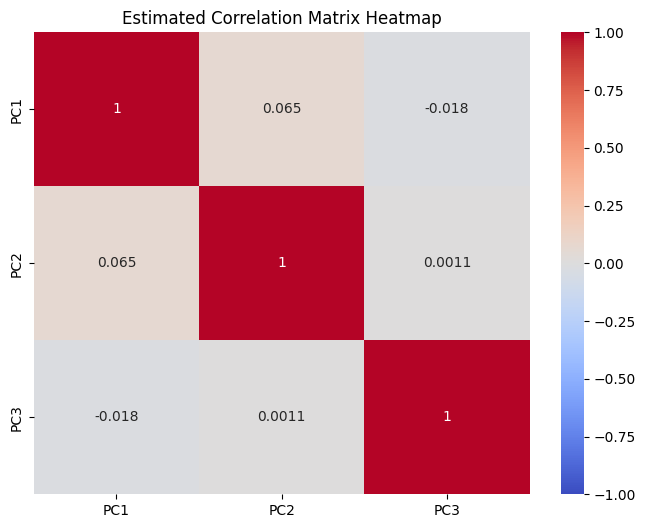

In [47]:
# Convert each marginal to uniforms using ranks
def rank_transform(series):
    ranks = series.rank(method='average')  # average rank for ties
    n = len(series)
    return ranks / (n + 1)

uniform_returns = PCs.apply(rank_transform, axis=0)

# Transform uniforms to standard normals using the inverse CDF
# Through the fact that CDF(Z) U where Z is standard normal and U is uniform 
# This gives us pseudo-observations that should be approximately normal.
z_factors = uniform_returns.apply(st.norm.ppf, axis=0)

# Estimate the correlation matrix from the pseudo-observations
# This correlation matrix is the parameter of our Gaussian copula.
estimated_corr_pca = z_factors.corr()
print("Estimated Correlation Matrix for Gaussian Copula:")
plt.figure(figsize=(8, 6))
sns.heatmap(estimated_corr_pca, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Estimated Correlation Matrix Heatmap")
plt.show()

In [48]:
n_simulations = 10000
# Generate simulated normals and convert to uniforms
simulated_normals = np.random.multivariate_normal(mean=np.zeros(n_components),
                                                  cov=estimated_corr_pca,
                                                  size=n_simulations)
simulated_uniforms = st.norm.cdf(simulated_normals)
# Clip to ensure values are within a safe range
simulated_uniforms = np.clip(simulated_uniforms, 1e-10, 1-1e-10)
simulated_uniforms_df = pd.DataFrame(simulated_uniforms, columns=z_factors.columns)

def empirical_inverse_cdf(series, u):
    # Remove any NaNs
    series = series.dropna()
    n = len(series)
    if n == 0:
        return np.nan
    # If the series is nearly constant, return its (unique) value.
    if np.allclose(series, series.iloc[0]):
        return series.iloc[0]
    sorted_series = np.sort(series)
    # Create a grid of cumulative probabilities avoiding exact 0 and 1
    p = np.linspace(1/(n+1), n/(n+1), n)
    return np.interp(u, p, sorted_series)


simulated_pca = pd.DataFrame({
    pc: simulated_uniforms_df[pc].apply(lambda u: empirical_inverse_cdf(PCs[pc], u))
    for pc in PCs.columns
})

# Reconstruction using the PCA loading matrix:
# For standardized data: diffdat_standardized ≈ (PC scores) * (eigenvectors)^T.
# To convert back to the original scale, invert the standardization:
reconstructed_standardized = simulated_pca.dot(eigenvectors.T)
reconstructed_returns = (reconstructed_standardized * std_diffdat) + mean_diffdat

# Create a DataFrame for the reconstructed returns
reconstructed_returns = pd.DataFrame(reconstructed_returns)#, columns=returns.columns)


weights = np.repeat(1/len(tickers), len(tickers))
simulated_portfolio_returns = reconstructed_returns.dot(weights)

alpha = 0.05
sim_VaR = np.percentile(simulated_portfolio_returns, alpha * 100)
sim_CVaR = simulated_portfolio_returns[simulated_portfolio_returns <= sim_VaR].mean()

print("Simulated Portfolio VaR (95%) from PCA-based copula:", sim_VaR)
print("Simulated Portfolio CVaR (95%) from PCA-based copula:", sim_CVaR)


Simulated Portfolio VaR (95%) from PCA-based copula: -0.02327442075296816
Simulated Portfolio CVaR (95%) from PCA-based copula: -0.030061264632311784


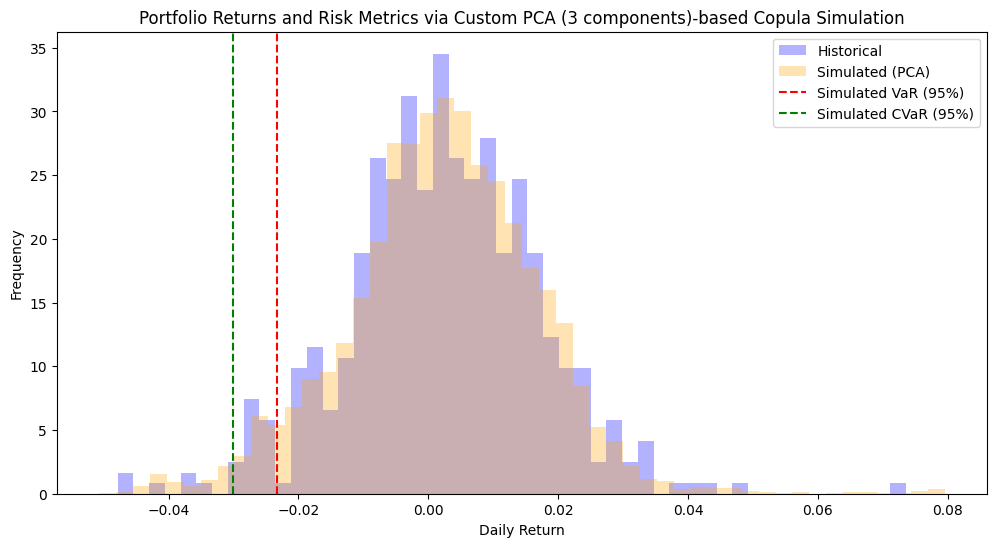

In [49]:

plt.figure(figsize=(12, 6))
plt.hist(returns.dot(weights), bins=50, alpha=0.3, color='blue',
         label='Historical', density=True)
plt.hist(simulated_portfolio_returns, bins=50, alpha=0.3, color='orange',
         label='Simulated (PCA)', density=True)
plt.axvline(sim_VaR, color='red', linestyle='--', label='Simulated VaR (95%)')
plt.axvline(sim_CVaR, color='green', linestyle='--', label='Simulated CVaR (95%)')
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.title("Portfolio Returns and Risk Metrics via Custom PCA (3 components)-based Copula Simulation")
plt.legend()
plt.show()

Optimal weights (minimizing tail risk): [0.86226431 0.         0.         0.         0.13773569 0.
 0.        ]
AAPL: 86.23%
MSFT: 0.00%
AMZN: 0.00%
GOOGL: 0.00%
META: 13.77%
NFLX: 0.00%
TSLA: 0.00%
Optimized Portfolio VaR (95%): -0.016267208367273803
Optimized Portfolio CVaR (95%): -0.021180169155986573


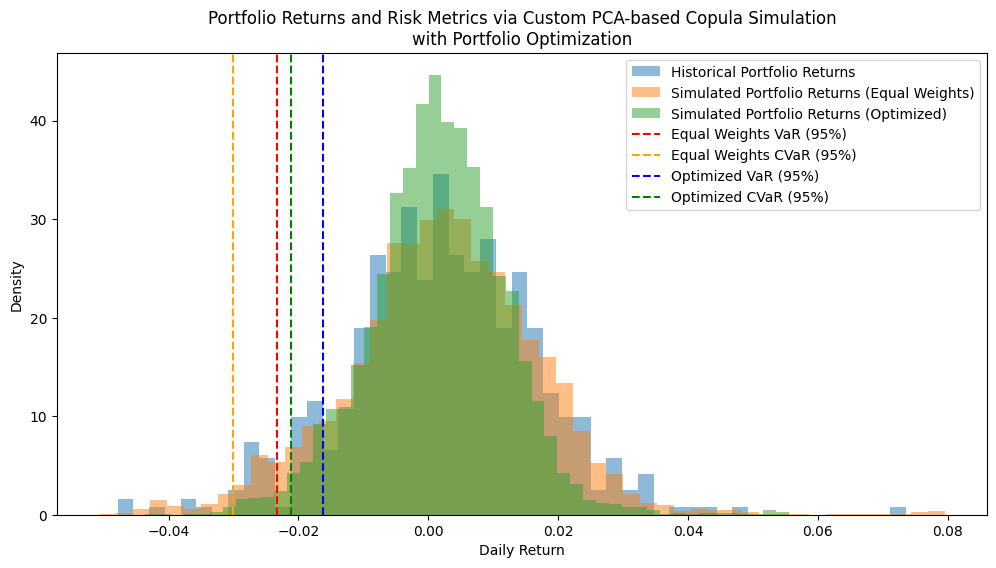

In [52]:
weights_equal = np.repeat(1/len(tickers), len(tickers))
def portfolio_cvar(weights, returns_data, alpha=0.05):
    # Calculate portfolio returns given weights.
    port_returns = returns_data.dot(weights)
    # Compute VaR as the alpha quantile.
    VaR = np.percentile(port_returns, alpha * 100)
    # Compute CVaR as the average return for outcomes below VaR.
    CVaR = port_returns[port_returns <= VaR].mean()
    # Since returns are typically negative for losses, a higher (less negative) CVaR is better.
    # We minimize the negative CVaR.
    return -CVaR

# Constraints: sum of weights = 1; bounds: weights between 0 and 1 (long-only)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))
initial_weights = np.repeat(1/len(tickers), len(tickers))

opt_result = minimize(portfolio_cvar, x0=initial_weights, args=(reconstructed_returns,), 
                      bounds=bounds, constraints=constraints)

optimal_weights = opt_result.x
print("Optimal weights (minimizing tail risk):", optimal_weights)
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.2%}")

# Recalculate risk metrics using optimized weights.
optimized_portfolio_returns = reconstructed_returns.dot(optimal_weights)
opt_sim_VaR = np.percentile(optimized_portfolio_returns, alpha * 100)
opt_sim_CVaR = optimized_portfolio_returns[optimized_portfolio_returns <= opt_sim_VaR].mean()

print("Optimized Portfolio VaR (95%):", opt_sim_VaR)
print("Optimized Portfolio CVaR (95%):", opt_sim_CVaR)

plt.figure(figsize=(12, 6))
# Plot historical portfolio returns (using equal weights from actual data)
plt.hist(returns.dot(weights_equal), bins=50, alpha=0.5, label='Historical Portfolio Returns', density=True)
# Plot simulated portfolio returns from PCA-based copula using equal weights
plt.hist(simulated_portfolio_returns, bins=50, alpha=0.5, label='Simulated Portfolio Returns (Equal Weights)', density=True)
# Plot simulated portfolio returns using optimized weights
plt.hist(optimized_portfolio_returns, bins=50, alpha=0.5, label='Simulated Portfolio Returns (Optimized)', density=True)

plt.axvline(sim_VaR, color='red', linestyle='--', label='Equal Weights VaR (95%)')
plt.axvline(sim_CVaR, color='orange', linestyle='--', label='Equal Weights CVaR (95%)')
plt.axvline(opt_sim_VaR, color='blue', linestyle='--', label='Optimized VaR (95%)')
plt.axvline(opt_sim_CVaR, color='green', linestyle='--', label='Optimized CVaR (95%)')

plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.title("Portfolio Returns and Risk Metrics via Custom PCA-based Copula Simulation\nwith Portfolio Optimization")
plt.legend()
plt.show()